# TimeSeries EDA, Group 4

Callie, Vincent, Blair

### Sources:

- For this assignment we used the examples from Canvas and Claude 3.5 LLM.


## Try to answer these questions before the EDA (use resources from web or AI tools (citation required))

- What patterns do you observe when you visualize time series data?
    - There are various patterns that can be observed from a time series dataset, such as trends (consistent increase/decrease of data), seasonality (repeating patterns tied to time periods), and cyclic patterns (repeating upward/downward patterns not tied to a fixed time period). All of the patterns are still tied to a time observation as the datapoints are collected in sequential, chronological order, and are evenly spaced out. This makes finding patterns helpful for predicting future values/patterns and analyzing current data based on time.

- How can time series data be represented visually? What are the different types of plots used to analyze time series data?
    - Time series data can be visualized in a number of different ways. Line plots are effective at showing how a value changes over time, and is the first plot most people associate with time series data. Variations of line plots include dual axis plots, seasonal plots, and rolling statistics plots. You can also use boxplots segmented by month or year to show data distribution in your time series data. Lag plots are another important method of data visualization for time series data.

- Can you identify the components of a time series (trend, seasonality, noise) from a sample dataset?
How can time series data be decomposed into these components?
    - Trend can be identified using moving averages.
    - We can identify the components of a time series dataset through decomposition, such as seasonal decomposition (https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).
    - With the trend and seasonality, any "leftovers" not explained are noise, which we can subtract.  
    - Source: https://miningthedetails.com/blog/r/TimeSeriesDecomposition/

- What is the difference between stationary and non-stationary time series data? Why does stationarity matter in time series analysis?
    - Stationary time series data is data who's statistical properties like mean and variance don't change over time. The data stays relatively consistent over time. Non-stationary time series data in contrast has statistical properties that do change; its mean and variance fluctuates as time progresses.

    - Stationary time series data matters because because many forecasting methods require data to be stationary to work properly. If data is non-stationary, differencing techniques can be used before applying a forecasting model to the data.

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Energy_dataset.csv')

# Set index to Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

df.index = pd.to_datetime(df.index)
print(df.head())
print(df.dtypes)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
PJME_MW    float64
dtype: object


In [6]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


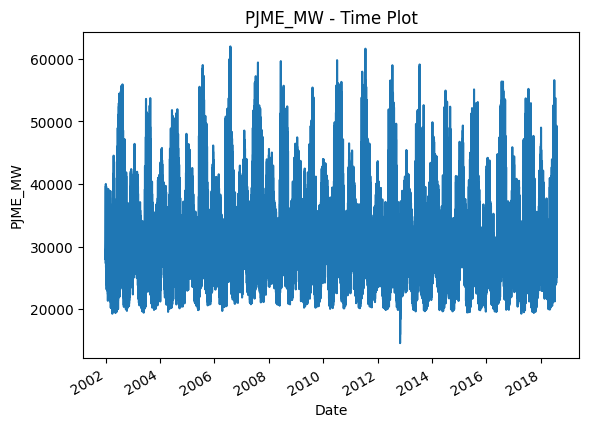

In [7]:
# Setting pyplot style

# Plot time series
plt.figure()
df['PJME_MW'].plot(title='PJME_MW - Time Plot')
plt.ylabel('PJME_MW')
plt.xlabel('Date')
plt.show()

In [8]:
#Step 3: Seasonal Plots

df['year'] = df.index.year
df['month'] = df.index.month
df.reset_index(inplace=True)
df['week'] = df['Datetime'].dt.isocalendar().week
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.dayofweek
df['day_str'] = df['Datetime'].dt.strftime('%a')
df['year_month'] = df['Datetime'].dt.strftime('%Y_%m')
df.set_index('Datetime', inplace=True)

In [9]:
df.head()

,PJME_MW,year,month,week,hour,day,day_str,year_month
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,12,1,1,1,Tue,2002_12
2002-12-31 02:00:00,25147.0,2002,12,1,2,1,Tue,2002_12
2002-12-31 03:00:00,24574.0,2002,12,1,3,1,Tue,2002_12
2002-12-31 04:00:00,24393.0,2002,12,1,4,1,Tue,2002_12
2002-12-31 05:00:00,24860.0,2002,12,1,5,1,Tue,2002_12


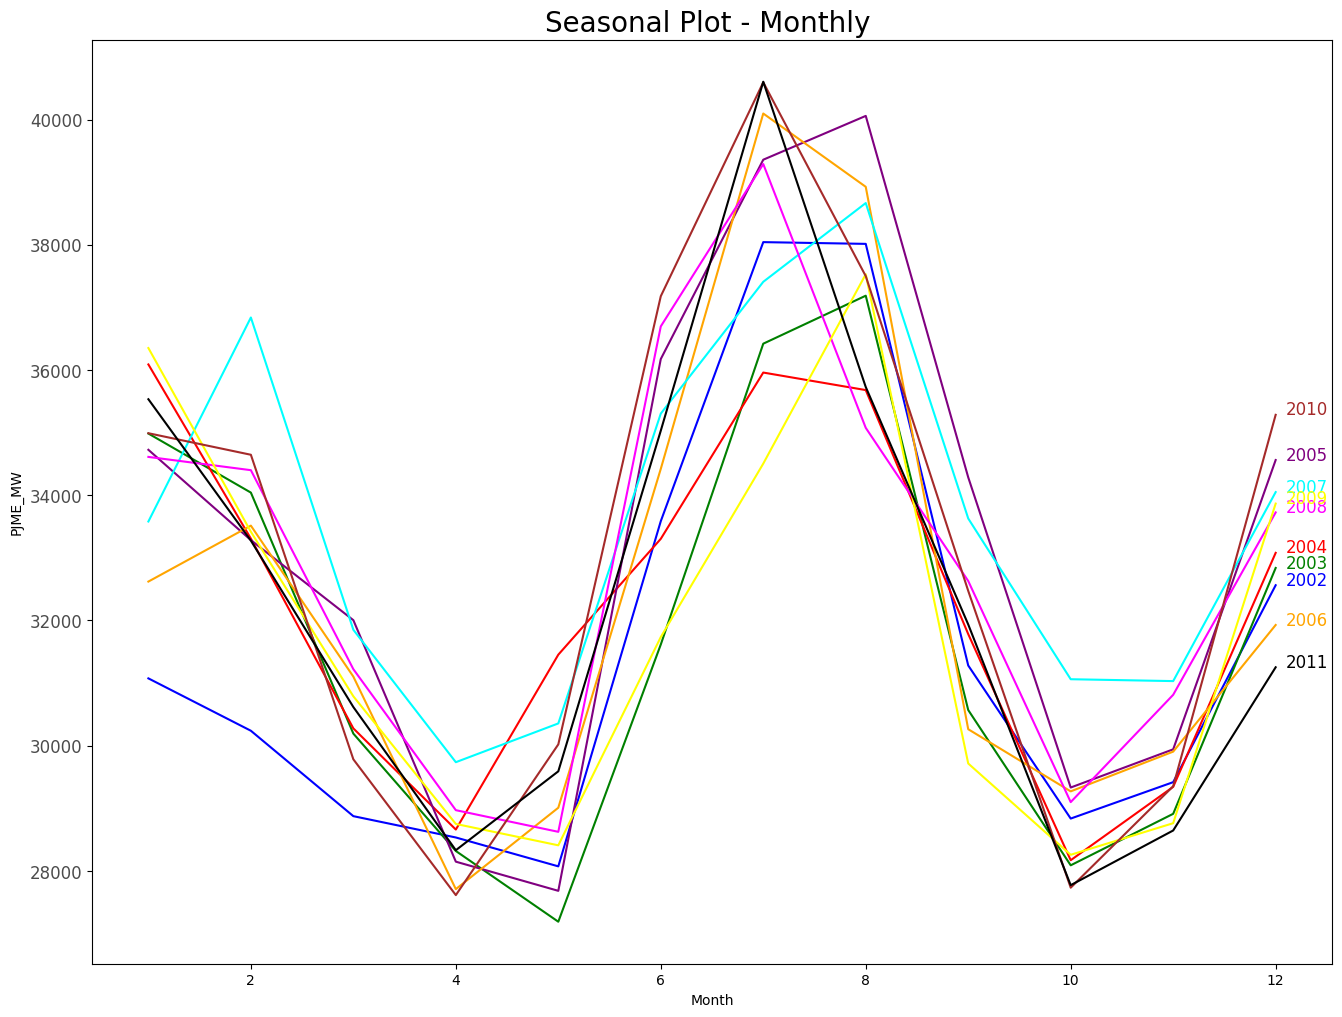

In [10]:
#Seasonal plot — Yearly

df_plot = df[['month', 'year', 'PJME_MW']].dropna().groupby(['month', 'year']).mean()[['PJME_MW']].reset_index()
years = df_plot['year'].unique()
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'black']

# Plotting
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i < len(colors):  # Ensuring we don't exceed the number of available colors
        plt.plot('month', 'PJME_MW', data=df_plot[df_plot['year'] == y], color=colors[i], label=y)
        if y == 2018:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.3, df_plot.loc[df_plot.year==y, 'PJME_MW'][-1:].values[0], y, fontsize=12, color=colors[i])
        else:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.1, df_plot.loc[df_plot.year==y, 'PJME_MW'][-1:].values[0], y, fontsize=12, color=colors[i])


# Setting labels and titles
plt.gca().set(ylabel= 'PJME_MW', xlabel = 'Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot - Monthly ", fontsize=20)
plt.ylabel('PJME_MW')
plt.xlabel('Month')
plt.show()

/tmp/ipykernel_51832/1462813302.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(months)).colors  # Using a colormap from matplotlib


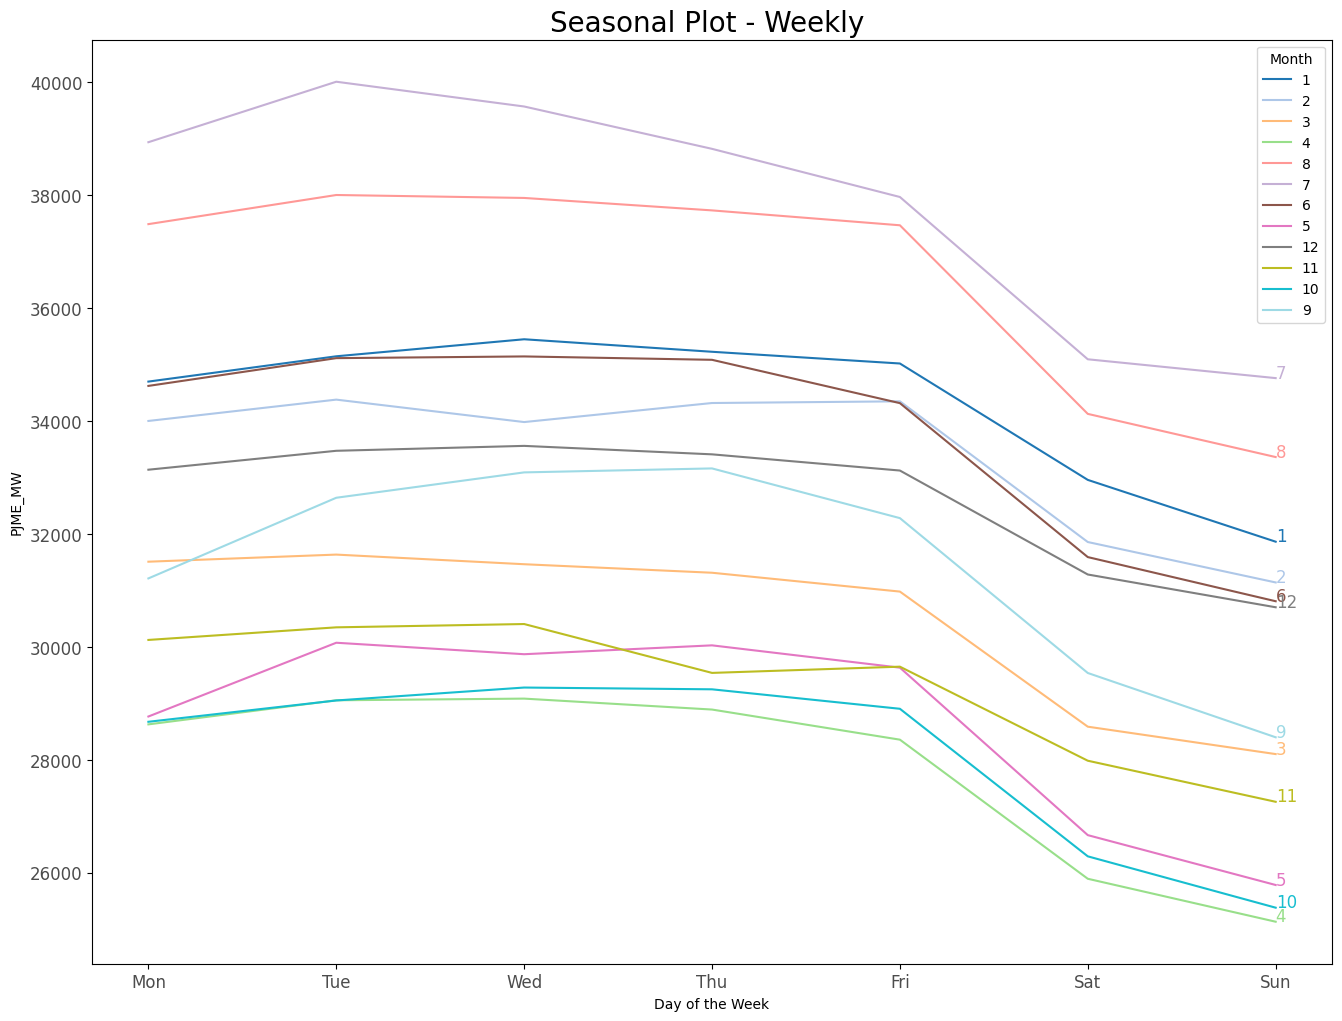

In [11]:
#Seasonal plot — Weekly
# Preparing the data
np.random.seed(42)
df_plot = df[['month', 'day_str', 'PJME_MW', 'day']].dropna()
df_plot = df_plot.groupby(['day_str', 'month', 'day']).mean()[['PJME_MW']].reset_index()
df_plot = df_plot.sort_values(by='day', ascending=True)

# Defining the color palette
months = df_plot['month'].unique()
colors = plt.cm.get_cmap('tab20', len(months)).colors  # Using a colormap from matplotlib

# Plotting
plt.figure(figsize=(16, 12))
for i, month in enumerate(months):
    month_data = df_plot[df_plot['month'] == month]
    plt.plot(month_data['day_str'], month_data['PJME_MW'], color=colors[i], label=month)
    plt.text(len(month_data['day_str']) - 1, month_data['PJME_MW'].iloc[-1], month, fontsize=12, color=colors[i])

# Setting labels and titles
plt.xlabel('Day of the Week')
plt.ylabel('PJME_MW')
plt.title('Seasonal Plot - Weekly ', fontsize=20)
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.legend(title='Month')
plt.show()

/tmp/ipykernel_51832/2841694758.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(months)).colors  # Using a colormap from matplotlib


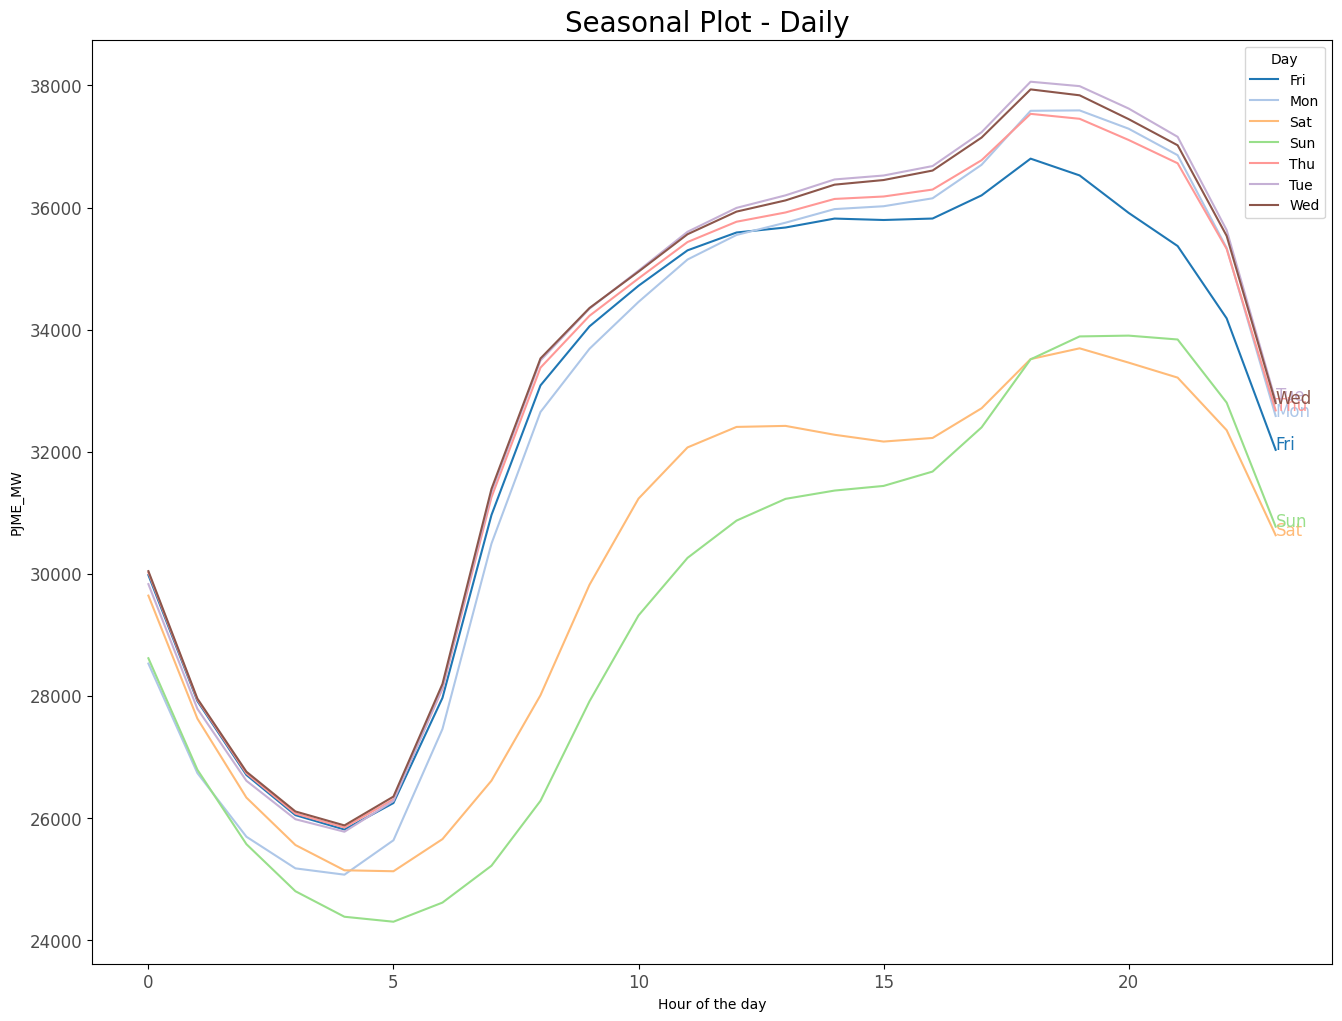

In [12]:
#Seasonal plot — Weekly
# Preparing the data
np.random.seed(42)
df_plot = df[['day_str', 'PJME_MW', 'hour']].dropna()
df_plot = df_plot.groupby(['day_str', 'hour']).mean()[['PJME_MW']].reset_index()
df_plot = df_plot.sort_values(by='hour', ascending=True)

# Defining the color palette
days = df_plot['day_str'].unique()
colors = plt.cm.get_cmap('tab20', len(months)).colors  # Using a colormap from matplotlib

# Plotting
plt.figure(figsize=(16, 12))
for i, day in enumerate(days):
    day_data = df_plot[df_plot['day_str'] == day]
    plt.plot(day_data['hour'], day_data['PJME_MW'], color=colors[i], label=day)
    plt.text(len(day_data['hour']) - 1, day_data['PJME_MW'].iloc[-1], day, fontsize=12, color=colors[i])

# Setting labels and titles
plt.xlabel('Hour of the day')
plt.ylabel('PJME_MW')
plt.title('Seasonal Plot - Daily ', fontsize=20)
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.legend(title='Day')
plt.show()

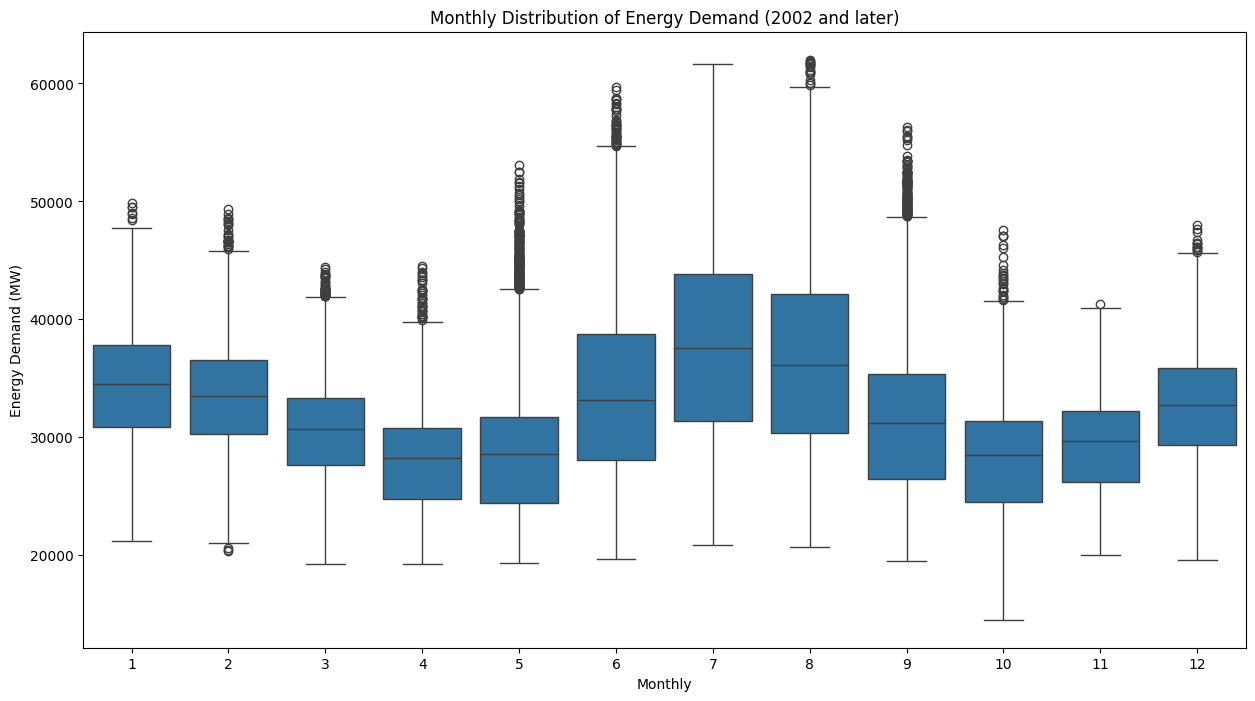

In [13]:
# Box plots

# extract the month for each date in the DataFrame
df['Month'] = df.index.month

plt.figure(figsize=(15,8))
sns.boxplot(data=df, x='Month', y='PJME_MW')
plt.xlabel('Monthly')
plt.ylabel('Energy Demand (MW)')
plt.title(f'Monthly Distribution of Energy Demand (2002 and later)');

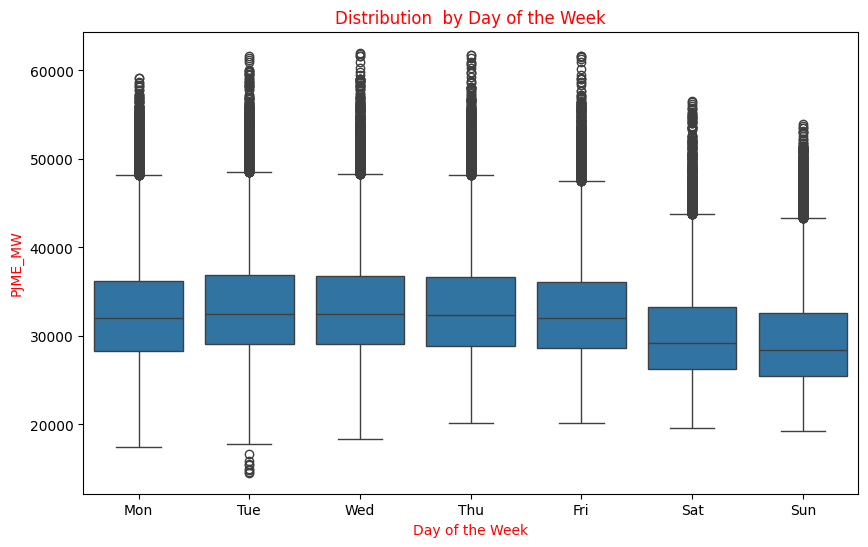

In [14]:
#Day
# Sorting the DataFrame by day of the week
df_plot = df[['day_str', 'day', 'PJME_MW']].sort_values(by='day')

# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_str', y='PJME_MW', data=df_plot)
plt.title('Distribution  by Day of the Week', color ='red')
plt.xlabel('Day of the Week', color ='red')
plt.ylabel('PJME_MW', color='red')
plt.show()

In [15]:
"""There doesn't seem to be a trend on the yearly time period, so
we will try monthly. See code cell below"""

# #Step 5: Time Series Decomposition
#
# #Importing relevant modeule
# from statsmodels.tsa.seasonal import seasonal_decompose
#
# # Filtering data for the year 2002 and reset index
# df_plot = df[df['year'] >= 2002].reset_index()
#
# # Removing duplicate entries and sort by date
# df_plot = df_plot.drop_duplicates(subset=['Datetime']).sort_values(by='Datetime')
# df_plot.sort_index(inplace=True)
#
# # Setting Datetime column as index
# df_plot = df_plot.set_index('Datetime')
#
# # Copying the 'Value' column for both additive and multiplicative decompose
# df_plot['Multiplicative Decompose'] = df_plot['PJME_MW']
# df_plot['Additive Decompose'] = df_plot['PJME_MW']
#
# # Performing additive decomposition
# result_add = seasonal_decompose(df_plot['Additive Decompose'], model='additive',period=1)
#
# # Performing multiplicative decomposition
# result_mul = seasonal_decompose(df_plot['Multiplicative Decompose'], model='multiplicative',period=1)
#
# # Plotting additive decomposition
# result_add.plot().suptitle('', fontsize=22)
# plt.xticks(rotation=45)
#
# # Plotting multiplicative decomposition
# result_mul.plot().suptitle('', fontsize=22)
# plt.xticks(rotation=45)
#
# # Displaying the plots
# plt.show()

"There doesn't seem to be a trend on the yearly time period, so\nwe will try monthly. See code cell below"

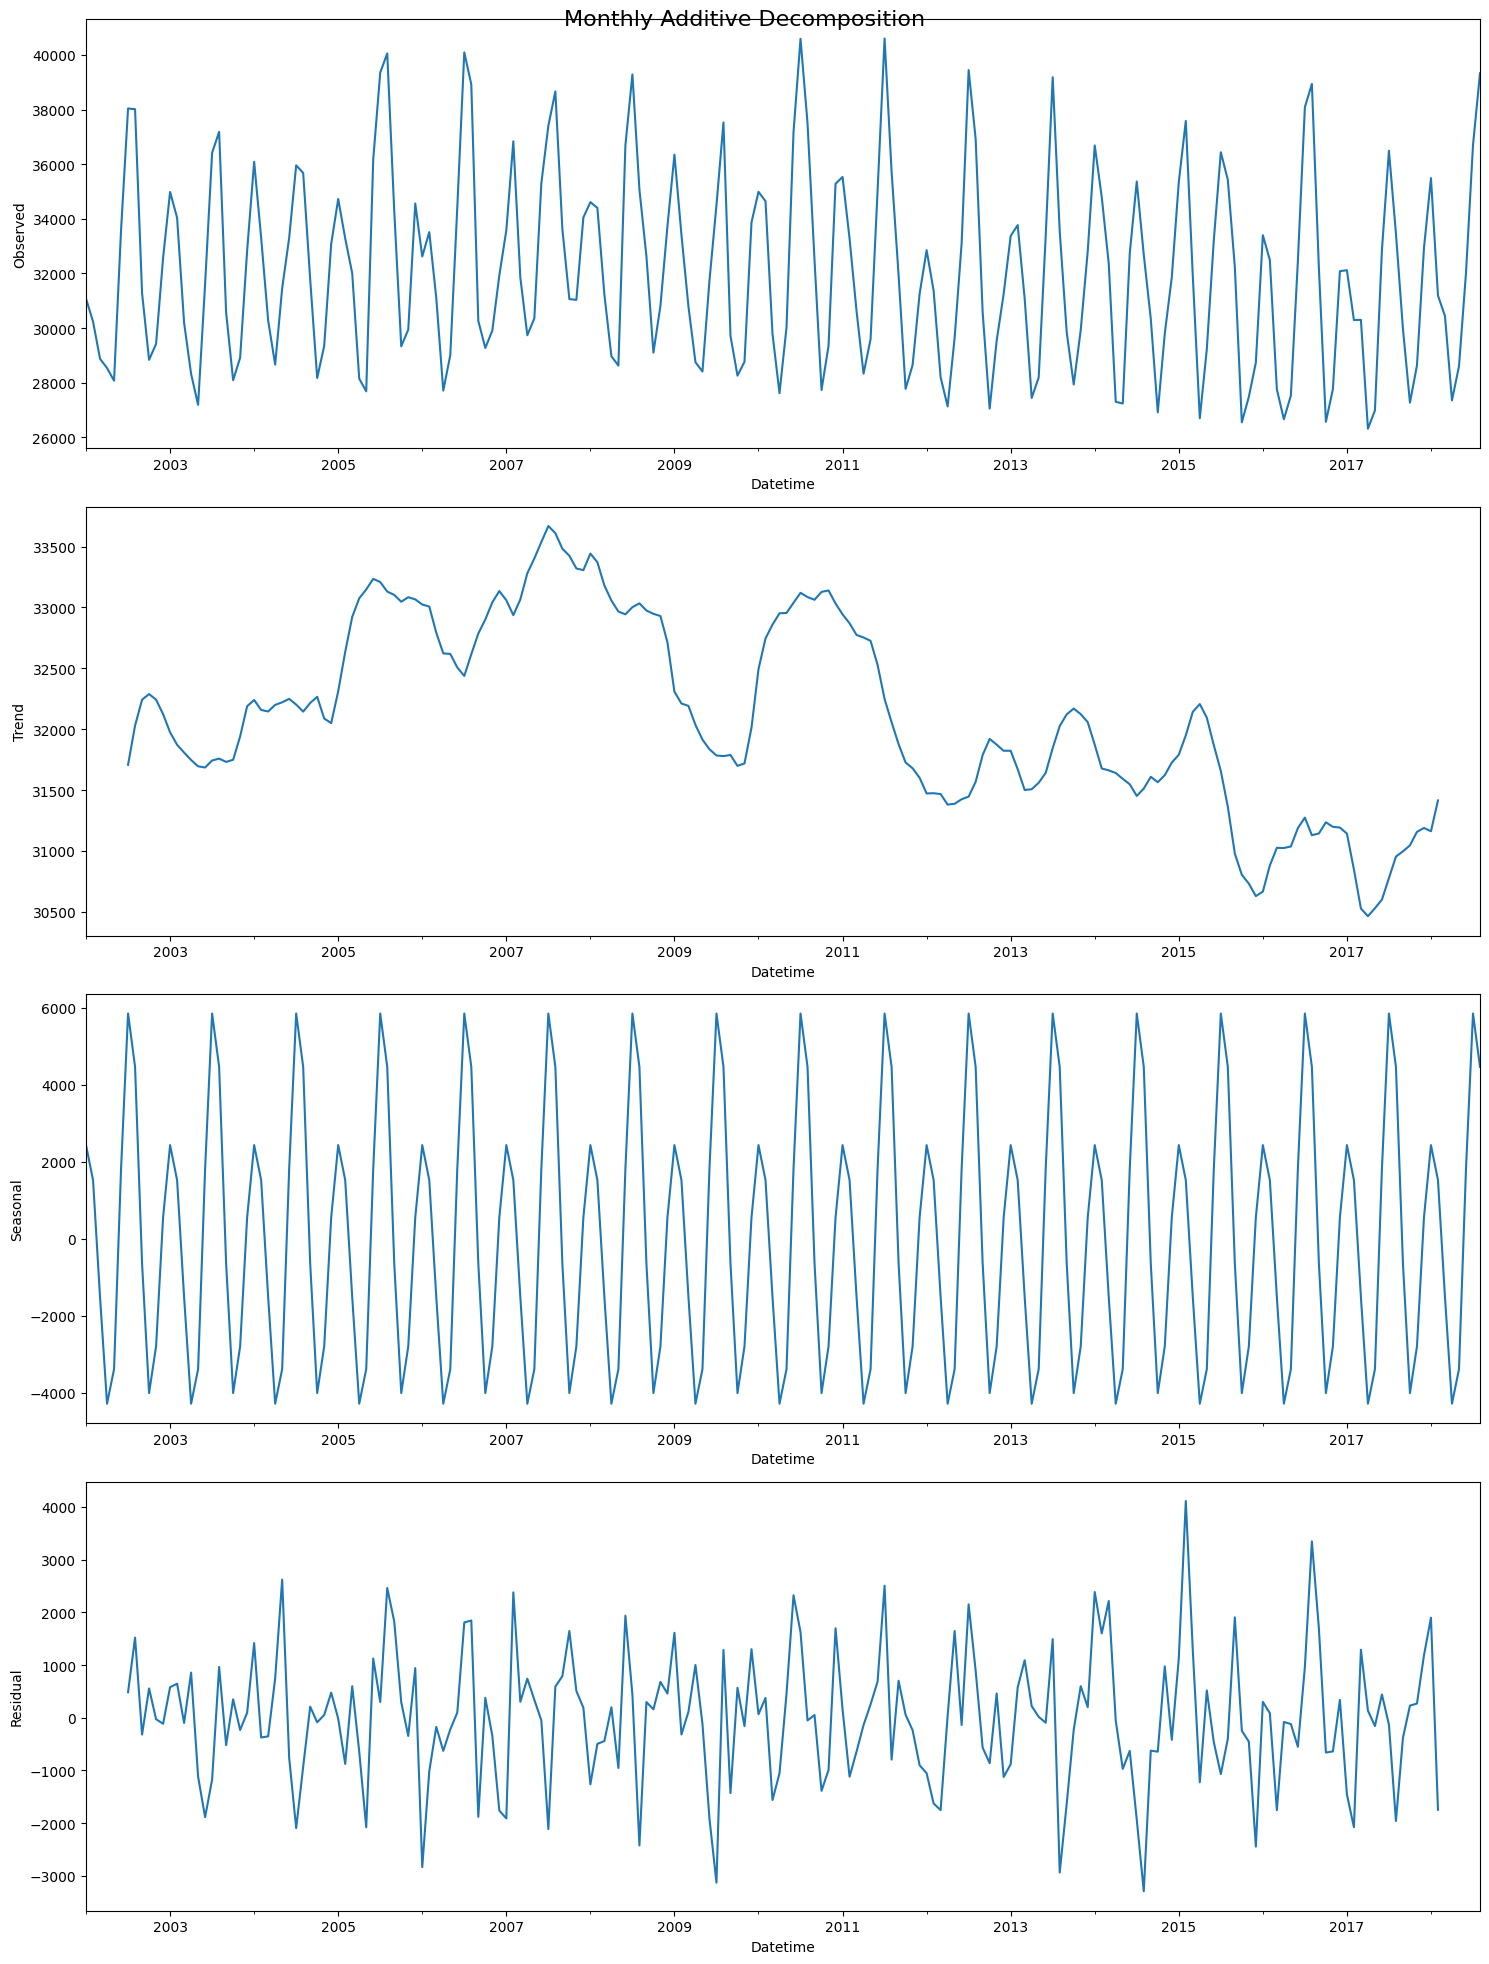

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample to monthly frequency
df_monthly = df['PJME_MW'].resample('ME').mean()

# Function to plot decomposition
def plot_decomposition(data, period, title):
    result = seasonal_decompose(data, model='additive', period=period)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    result.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    result.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    result.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    result.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')

    plt.tight_layout()
    plt.show()

# Monthly decomposition
plot_decomposition(df_monthly, period=12, title='Monthly Additive Decomposition')

# Yearly decomposition
# plot_decomposition(df_yearly, period=1, title='Yearly Additive Decomposition')

In [17]:
import plotly.express as px

data_monthly = df['PJME_MW'].resample('ME').mean()

# Create Lag Plot
def interactive_lag_plot():
    lag = 12
    # Creating a DataFrame for lagged values
    data_lag = pd.DataFrame({'Original': data_monthly, 'Lagged': data_monthly.shift(lag)  # Lagging by 1 period
                        }).dropna()  # Drop rows where the lagged value is NaN

    # Scatter plot of Original vs. Lagged values
    fig = px.scatter(data_lag, x='Lagged', y='Original', title=f'Lag Plot: PJME_MW Lagged by {lag} Period(s)')
    fig.show()

# Running the interactive lag plot function
interactive_lag_plot()

<Figure size 1200x600 with 0 Axes>

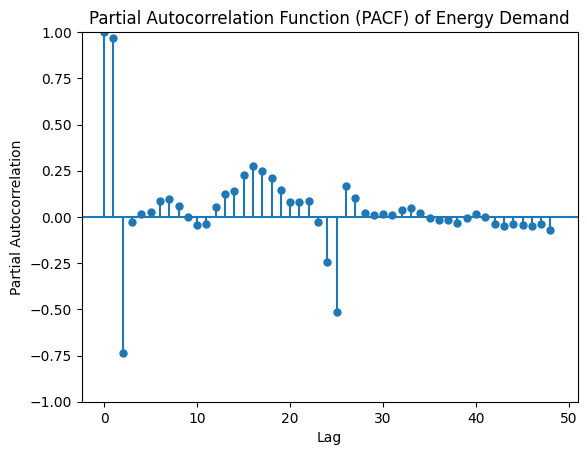

<Figure size 1200x600 with 0 Axes>

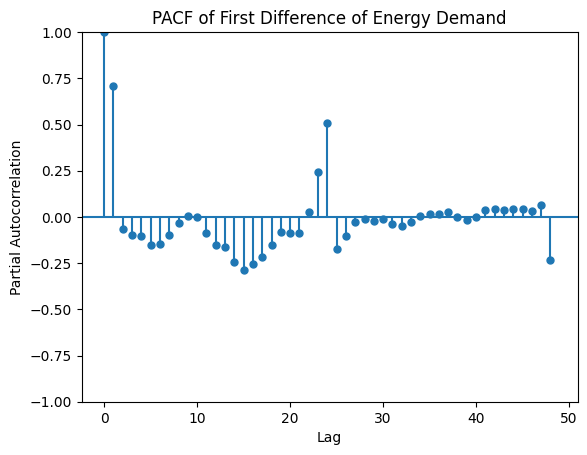

count    145366.000000
mean      32080.222831
std        6464.012166
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF of original series
plt.figure(figsize=(12, 6))
plot_pacf(df['PJME_MW'], lags=48, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of Energy Demand')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Plot PACF of first difference
plt.figure(figsize=(12, 6))
plot_pacf(df['PJME_MW'].diff().dropna(), lags=48, alpha=0.05)
plt.title('PACF of First Difference of Energy Demand')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Print basic statistics
print(df['PJME_MW'].describe())